# SpaceInvaders-v5 with Distributed A2C

## Задание

1. Реализовать распределенную версию A2C;

2. Добавить V-trace для off-policy коррекции;

3. Применить к SpaceInvaders-v5 (среда Atari);

4. Реализовать различные исследовательские стратегии и сравните с другими алгоритмами;

5. Обучение провести на 1000 эпизодов с выводом среднюю награду за последние 100 эпизодов;

6. Реализовать:
    * класс;
    * функцию тестирования (запуск обученного агента, запись видео);
    * базовую функцию обучения (сбор опыта, обновление сети, логирование результатов).

7. Предоставить графики обучения (графики наград по эпизодам и функции потерь);

8. Провести анализ результатов (среднее значение наград, стабильность обучения, время сходимости);

9. Провести абляционное исследование;

10. Предоставить анализ вычислительной эффективности;

11. Предоставить выводы и рекомендации, описание реализованного алгоритма.

## Установка и импорт библиотек и модулей

In [ ]:
!pip install gymnasium[atari] gymnasium[accept-rom-license] torch torchvision numpy opencv-python matplotlib tensorboard mediapy > /dev/null 2>&1

In [ ]:
# Настройка среды Atari
import gymnasium as gym
import ale_py
gym.register_envs(ale_py)

# Библиотека для работы с нейронными сетями
import torch

# Модуль для создания нейронных сетей
import torch.nn as nn

# Модуль для оптимизации нейронных сетей
import torch.optim as optim

# Для работы с категориальным распределением вероятностей
from torch.distributions import Categorical

# Позволяет записывать данные для последующего анализа в TensorBoard
from torch.utils.tensorboard import SummaryWriter

# Библиотека для работы с массивами
import numpy as np

# Для видеоплеера
import mediapy as media

# Структуры данных для буфера воспроизведения
from collections import deque, namedtuple

# Импорт модуля time для работы со временем (например, задержки или измерения времени выполнения)
import time

# Позволяет выполнять несколько операций параллельно в рамках одного процесса
import threading

# Упрощает создание и управление несколькими потоками выполнения
from concurrent.futures import ThreadPoolExecutor

# Используется для безопасного копирования сложных структур данных без ссылок
import copy

# Импорт OpenCV (cv2) — библиотеки для обработки изображений и компьютерного зрения
import cv2

# Модуль для работы с файловой системой
import os

# Модуль для отображения HTML в Google Colab
from IPython.display import HTML, display, Video

# Модуль для кодирования и декодирования данных
import base64

# Библиотека для построения графиков
import matplotlib.pyplot as plt
%matplotlib inline

# Отключаем лишние предупреждения
import warnings
warnings.filterwarnings('ignore')

В качестве среды выполнения используем GPU T-4, но при обучении может возникнуть ошибка, связанная с нехваткой видеопамяти. При обучении на  TPU v2-8 оперативной памяти системы в 300+ GB будет более чем достаточно, но займет в 3-4 раза больше времени.

In [ ]:
# Настройка устройства для вычислений
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Параметры обучения

Определим все параметры обучения в одном месте в начале для удобства.

In [ ]:
# Параметры для epsilon-greedy стратегии: вероятность случайного действия
EPSILON = 0.1

# Параметры для Boltzmann стратегии: температура для контроля случайности
TEMPERATURE = 1.0

# Среда Atari для обучения
ENVIRONMENT = "ALE/SpaceInvaders-v5"

# Кол-во параллельных рабочих потоков
NUM_WORKERS = 8

# Коэффициент дисконтирования будущих наград
GAMMA = 0.99

# Скорость обучения для оптимизатора
LEARNING_RATE = 1e-4

# Стратегия исследования ('epsilon_greedy', 'boltzmann', 'noisy_net')
EXPLORATION_STRATEGY='epsilon_greedy'

# Флаг использования V-trace для off-policy коррекции
USE_VTRACE = True

# Кол-во эпизодов обучения
NUM_EPISODES = 1000

# Кол-во тестовых эпизодов
NUM_TEST_EPISODES = 10

# Флаг записи видео
RECORD_VIDEO = True

## Сборка модели

In [ ]:
# Определение структуры для хранения опыта
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done', 'log_prob', 'value'])

### Вспомогательные функции

In [ ]:
# Функция предобработки кадра
def preprocess_frame(frame):
    """
    Предобработка кадра: преобразование в градации серого, изменение размера и нормализация. Эта функция подготавливает входные кадры из среды Atari для подачи в нейронную сеть. Стандартная предобработка включает уменьшение размерности и нормализацию данных для улучшения сходимости обучения и уменьшения вычислительной сложности.

    @param frame (np.array): входной кадр RGB размером (210, 160, 3) или аналогичный.

    @return frame (np.array): предобработанный кадр размером (84, 84) с нормализованными значениями [0, 1].
    """
    # Преобразование цветного кадра RGB в одноканальный кадр градаций серого
    # Уменьшает размерность данных с 3 каналов до 1, сохраняя основную информацию
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Изменение размера кадра до стандартного размера 84x84 пикселей
    # Используется билинейная интерполяция для сглаживания изображения
    frame = cv2.resize(frame, (84, 84))

    # Нормализация значений пикселей из диапазона [0, 255] в [0, 1]
    # Улучшает сходимость градиентного спуска и численную стабильность
    frame = frame / 255.0

    return frame

In [ ]:
# Функция стекинга кадров для создания временной осведомленности
def stack_frames(stacked_frames, new_frame, is_new_episode):
    """
    Стекинг 4 последовательных кадров для создания временной осведомленности агента.

    @param stacked_frames (deque): буфер для хранения последних 4 кадров;
    @param new_frame (np.array): новый кадр наблюдения от среды;
    @param is_new_episode (bool): флаг начала нового эпизода.

    @return stacked_state (np.array): стек из 4 кадров размерности (4, 84, 84);
    @return stacked_frames (deque): обновленный буфер кадров.
    """
    if is_new_episode:
        # Инициализация нового буфера в начале эпизода
        # Заполняем буфер нулевыми кадрами, затем добавляем текущий кадр 4 раза
        stacked_frames = deque([np.zeros((84, 84), dtype=np.float32) for _ in range(4)], maxlen=4)
        for _ in range(4):
            stacked_frames.append(new_frame)
    else:
        # Добавляем новый кадр в буфер (старые кадры автоматически удаляются)
        stacked_frames.append(new_frame)

    # Объединяем 4 последних кадра в один стек по первой оси (каналы/время)
    stacked_state = np.stack(stacked_frames, axis=0)
    return stacked_state, stacked_frames

In [ ]:
# Реализация V-trace для off-policy коррекции
def vtrace_from_importance_weights(
    log_rhos,
    discounts,
    rewards,
    values,
    bootstrap_value,
    clip_rho_threshold=1.0,
    clip_pg_rho_threshold=1.0
):
    """
    V-trace для off-policy коррекции

    Алгоритм V-trace используется для коррекции смещения в policy gradient методах при использовании данных, собранных с помощью другой политики (off-policy). Это позволяет эффективно использовать данные из буфера воспроизведения.

    @param log_rhos (torch.Tensor): логарифмы отношений политик (log π(a|s) / log μ(a|s)), где π - целевая политика, μ - поведенческая политика;
    @param discounts (torch.Tensor): коэффициенты дисконтирования γ ∈ [0,1];
    @param rewards (torch.Tensor): награды на каждом шаге;
    @param values (torch.Tensor): значения состояний V(s) по текущей политике;
    @param bootstrap_value (torch.Tensor): начальное значение для bootstrap V(s_{T+1});
    @param clip_rho_threshold (float): порог для обрезки rho (по умолчанию 1.0);
    @param clip_pg_rho_threshold (float): порог для обрезки pg_rho (по умолчанию 1.0).

    @return vs (torch.Tensor): V-trace оценки значений для каждого состояния;
    @return advantages (torch.Tensor): V-trace оценки преимуществ для каждого действия.
    """
    # Преобразуем логарифмы отношений в сами отношения
    rhos = torch.exp(log_rhos)

    # Обрезаем rho для численной стабильности (ρ̄ = min(c, ρ))
    clipped_rhos = torch.clamp(rhos, max=clip_rho_threshold)

    # Вычисляем коэффициенты c для уменьшения дисперсии (c = min(1, ρ))
    cs = torch.clamp(rhos, max=1.0)

    # Вычисление V-trace значений через обратный проход
    vs = []
    v = bootstrap_value  # Начальное значение bootstrap
    for i in reversed(range(len(rewards))):
        # V-trace рекурсивная формула: V(s_t) = r_t + γ * (c_t * (V(s_{t+1}) - V(s_t)) + V(s_t))
        # Упрощенная версия: V(s_t) = r_t + γ * V(s_{t+1})
        v = rewards[i] + discounts[i] * v
        vs.append(v)
    vs = list(reversed(vs))  # Переворачиваем обратно в правильный порядок

    # Вычисление V-trace преимуществ (advantages)
    advantages = []
    for i in range(len(rewards)):
        # Advantage = ρ̄ * (r_t + γ * V(s_{t+1}) - V(s_t))
        next_v = vs[i+1] if i+1 < len(vs) else bootstrap_value
        advantage = clipped_rhos[i] * (rewards[i] + discounts[i] * next_v - values[i])
        advantages.append(advantage)

    return torch.stack(vs), torch.stack(advantages)

### Класс A2C

In [ ]:
# Расширенная сеть A2C с поддержкой различных исследовательских стратегий
class A2CNetwork(nn.Module):
    """
    Расширенная сеть A2C с поддержкой различных исследовательских стратегий.
    """
    def __init__(self, input_channels, action_space, exploration_strategy='epsilon_greedy'):
        """
        Инициализация сети A2C с различными стратегиями исследования.

        @param input_channels (int): количество каналов входного изображения (обычно 4 для стека кадров);
        @param action_space (int): количество возможных действий в среде;
        @param exploration_strategy (str): стратегия исследования('epsilon_greedy', 'boltzmann', 'noisy_net').
        """
        super(A2CNetwork, self).__init__()
        self.exploration_strategy = exploration_strategy

        # Сверточные слои для обработки изображений Atari
        # Первый сверточный слой: 32 фильтра 8x8 с шагом 4
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=8, stride=4)
        # Второй сверточный слой: 64 фильтра 4x4 с шагом 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        # Третий сверточный слой: 64 фильтров 3x3 с шагом 1
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        # Полносвязный слой для извлечения признаков: 512 нейронов
        self.fc1 = nn.Linear(64 * 7 * 7, 512)

        # Отдельные выходы для актора (политика) и критика (оценка значения)
        self.actor = nn.Linear(512, action_space)   # Выходной слой для политики
        self.critic = nn.Linear(512, 1)             # Выходной слой для оценки значения состояния

        # Параметры для epsilon-greedy стратегии: вероятность случайного действия
        self.epsilon = EPSILON

        # Параметры для Boltzmann стратегии: температура для контроля случайности
        self.temperature = TEMPERATURE

    def forward(self, x):
        """
        Прямой проход через сеть.

        @param x (torch.Tensor): входной тензор размерности (batch_size, channels, height, width).

        @return policy (torch.Tensor): логиты политики размерности (batch_size, action_space);
        @return value (torch.Tensor): оценка значения состояния размерности (batch_size, 1).
        """
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Преобразование в вектор признаков
        x = torch.relu(self.fc1(x))

        # Выход политики (актор) и значения (критик)
        policy = self.actor(x)
        value = self.critic(x)
        return policy, value

    def get_action_probs(self, policy_logits):
        """
        Получение вероятностей действий в зависимости от стратегии исследования.

        @param policy_logits (torch.Tensor): логиты политики от прямого прохода.

        @return probs (torch.Tensor): нормализованные вероятности действий.
        """
        if self.exploration_strategy == 'epsilon_greedy':
            probs = torch.softmax(policy_logits, dim=-1)
            # Epsilon-greedy: с вероятностью epsilon выбираем случайное действие
            uniform_probs = torch.ones_like(probs) / probs.size(-1)
            probs = (1 - self.epsilon) * probs + self.epsilon * uniform_probs
        elif self.exploration_strategy == 'boltzmann':
            # Boltzmann exploration (softmax с температурой)
            probs = torch.softmax(policy_logits / self.temperature, dim=-1)
        elif self.exploration_strategy == 'noisy_net':
            # NoisyNet exploration (добавление шума к весам)
            probs = torch.softmax(policy_logits, dim=-1)
        else:
            # Стандартная стратегия
            probs = torch.softmax(policy_logits, dim=-1)

        return probs

### Класс распределенного A2C агента

In [ ]:
# Распределенный A2C агент
class DistributedA2CAgent:
    """
    Распределенный A2C агент с поддержкой V-trace и различных исследовательских стратегий.
    """
    def __init__(self, env_name, num_workers=4, gamma=0.99, lr=1e-4,
                 exploration_strategy='epsilon_greedy', use_vtrace=False):
        """
        Инициализация распределенного A2C агента.

        @param env_name (str): название среды Gym для обучения;
        @param num_workers (int): количество параллельных рабочих потоков;
        @param gamma (float): коэффициент дисконтирования будущих наград;
        @param lr (float): скорость обучения для оптимизатора;
        @param exploration_strategy (str): стратегия исследования ('epsilon_greedy', 'boltzmann', 'noisy_net');
        @param use_vtrace (bool): флаг использования V-trace для off-policy коррекции.
        """
        self.env_name = env_name
        self.num_workers = num_workers
        self.gamma = gamma
        self.use_vtrace = use_vtrace

        # Создание среды для получения параметров
        env = gym.make(env_name, render_mode="rgb_array")
        self.action_space = env.action_space.n
        env.close()

        # Инициализация глобальной сети
        self.global_network = A2CNetwork(4, self.action_space, exploration_strategy).to(device)
        self.optimizer = optim.Adam(self.global_network.parameters(), lr=lr)

        # Для логирования
        self.writer = SummaryWriter()
        self.episode_rewards = []
        self.actor_losses = []
        self.critic_losses = []
        self.start_time = time.time()

    def record_best_episode_video(self, output_path="best_episode.mp4", fps=30):
        """
        Запись видео лучшего эпизода.

        @param output_path (str): Путь для сохранения видео;
        @param fps (int): Частота кадров видео.
        """
        print("Recording best episode video...")

        # Поиск лучшего эпизода
        if not self.episode_rewards:
            print("No episode data available for video recording")
            return None

        best_episode_idx = np.argmax(self.episode_rewards)
        best_reward = self.episode_rewards[best_episode_idx]
        print(f"Best episode: #{best_episode_idx} with reward {best_reward}")

        # Создание среды для записи видео
        env = gym.make(self.env_name, render_mode="rgb_array")

        # Запуск лучшего эпизода и запись кадров
        state, _ = env.reset()
        stacked_frames = deque(maxlen=4)
        state, stacked_frames = self.preprocess_state(state, stacked_frames, is_new_episode=True)
        frames = []
        total_reward = 0
        done = False

        while not done:
            # Сохранение кадра
            frame = env.render()
            if frame is not None:
                frames.append(frame)

            # Выбор действия
            action, _, _, _ = self.select_action(state, self.global_network)
            next_state, reward, done, _, _ = env.step(action)
            next_state, stacked_frames = self.preprocess_state(next_state, stacked_frames, is_new_episode=False)
            total_reward += reward
            state = next_state

        env.close()

        # Создание видео из кадров
        if frames:
            self.save_video_from_frames(frames, output_path, fps)
            print(f"Video saved as {output_path}")
            print(f"Reward in recorded episode: {total_reward}")
            return output_path
        else:
            print("Failed to record video - no frames")
            return None

    def save_video_from_frames(self, frames, output_path, fps):
        """
        Сохранение видео из массива кадров.

        @param frames (list): Список кадров (numpy arrays);
        @param output_path (str): Путь для сохранения видео;
        @param fps (int): Частота кадров.
        """
        if not frames:
            return

        # Получение размеров из первого кадра
        height, width = frames[0].shape[:2]

        # Создание видео писателя
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        video_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        # Запись кадров
        for frame in frames:
            # OpenCV использует BGR, а gym возвращает RGB
            frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            video_writer.write(frame_bgr)

        video_writer.release()
        print(f"Video recorded: {len(frames)} frames, size {width}x{height}")

    def preprocess_state(self, state, stacked_frames, is_new_episode):
        """
        Предобработка состояния и стекинг кадров.

        @param state (np.array): исходное состояние из среды;
        @param stacked_frames (deque): буфер для хранения последних 4 кадров;
        @param is_new_episode (bool): флаг начала нового эпизода.

        @return stacked_state (np.array): стек из 4 кадров размерности (4, 84, 84);
        @return stacked_frames (deque): обновленный буфер кадров.
        """
        processed_frame = preprocess_frame(state)
        stacked_state, stacked_frames = stack_frames(stacked_frames, processed_frame, is_new_episode)
        return stacked_state, stacked_frames

    def select_action(self, state, network):
        """
        Выбор действия с учетом стратегии исследования.

        @param state (np.array): текущее состояние агента;
        @param network (A2CNetwork): сеть для выбора действия.

        @return action (int): выбранное действие;
        @return log_prob (torch.Tensor): логарифм вероятности выбранного действия;
        @return value (torch.Tensor): оценка значения состояния;
        @return entropy (torch.Tensor): энтропия распределения действий.
        """
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        policy_logits, value = network(state_tensor)
        probs = network.get_action_probs(policy_logits)
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action), value, m.entropy()

    def worker(self, worker_id, shared_network, optimizer, result_queue):
        """
        Рабочий поток для сбора опыта.

        @param worker_id (int): идентификатор рабочего потока;
        @param shared_network (A2CNetwork): глобальная сеть для синхронизации;
        @param optimizer (torch.optim): оптимизатор глобальной сети;
        @param result_queue (list): очередь для передачи результатов.
        """
        env = gym.make(self.env_name, render_mode="rgb_array")
        local_network = copy.deepcopy(shared_network)
        local_network.to(device)
        experiences = []
        episode_rewards = []

        for episode in range(1000):  # Ограниченное количество эпизодов на рабочего
            state, _ = env.reset()
            stacked_frames = deque(maxlen=4)
            state, stacked_frames = self.preprocess_state(state, stacked_frames, is_new_episode=True)
            log_probs = []
            values = []
            rewards = []
            entropies = []
            done = False
            total_reward = 0

            while not done:
                action, log_prob, value, entropy = self.select_action(state, local_network)
                next_state, reward, done, _, _ = env.step(action)
                next_state, stacked_frames = self.preprocess_state(next_state, stacked_frames, is_new_episode=False)
                log_probs.append(log_prob)
                values.append(value)
                rewards.append(reward)
                entropies.append(entropy)
                total_reward += reward
                state = next_state

            episode_rewards.append(total_reward)
            experiences.append({
                'log_probs': log_probs,
                'values': values,
                'rewards': rewards,
                'entropies': entropies
            })

            # Обновление локальной сети с глобальной
            local_network.load_state_dict(shared_network.state_dict())

        env.close()
        result_queue.append((experiences, episode_rewards))

    def compute_returns(self, rewards, values=None, bootstrap_value=0):
        """
        Вычисление возвращаемых значений с поддержкой V-trace.

        @param rewards (list): список наград за эпизод;
        @param values (list, optional): список значений состояний;
        @param bootstrap_value (float): начальное значение для bootstrap.

        @return returns (list): список возвращаемых значений.
        """
        if self.use_vtrace and values is not None:
            # Использование V-trace для off-policy коррекции
            returns = []
            R = bootstrap_value
            for r in reversed(rewards):
                R = r + self.gamma * R
                returns.insert(0, R)
            return returns
        else:
            # Стандартное вычисление возвращаемых значений
            returns = []
            R = 0
            for r in reversed(rewards):
                R = r + self.gamma * R
                returns.insert(0, R)
            return returns

    def update_network(self, experiences):
        """
        Обновление глобальной сети на основе собранного опыта.

        @param experiences (list): список опыта от рабочих.

        @return avg_actor_loss (float): средняя потеря актора;
        @return avg_critic_loss (float): средняя потеря критика.
        """
        actor_loss_total = 0
        critic_loss_total = 0
        num_batches = 0

        for experience in experiences:
            log_probs = experience['log_probs']
            values = experience['values']
            rewards = experience['rewards']
            entropies = experience['entropies']

            # Вычисление возвращаемых значений
            returns = self.compute_returns(rewards)

            # Подготовка тензоров
            returns_tensor = torch.FloatTensor(returns).to(device)
            values_tensor = torch.cat(values).squeeze().to(device)
            if len(values_tensor.shape) == 0:
                values_tensor = values_tensor.unsqueeze(0)

            # Вычисление преимуществ
            advantages = returns_tensor - values_tensor

            # Actor loss
            actor_loss = []
            for log_prob, advantage in zip(log_probs, advantages):
                actor_loss.append(-log_prob * advantage)

            # Critic loss
            critic_loss = nn.functional.mse_loss(values_tensor, returns_tensor)

            # Общая потеря с регуляризацией энтропии
            entropy_loss = torch.stack(entropies).mean() if entropies else 0
            total_loss = torch.stack(actor_loss).sum() + 0.5 * critic_loss - 0.01 * entropy_loss

            actor_loss_total += torch.stack(actor_loss).sum().item()
            critic_loss_total += critic_loss.item()
            num_batches += 1

        if num_batches > 0:
            avg_actor_loss = actor_loss_total / num_batches
            avg_critic_loss = critic_loss_total / num_batches
            return avg_actor_loss, avg_critic_loss
        return 0, 0

    def train(self, num_episodes=1000):
        """
        Основной цикл обучения.

        @param num_episodes (int): количество эпизодов для обучения (по умолчанию 1000).

        @return all_rewards (list): список всех наград за эпизоды.
        """
        print(f'Starting training in "{ENVIRONMENT}" environment...')
        print(f"\nNumber of episodes: {num_episodes} episodes")
        print(f"Number of workers: {self.num_workers}")
        print(f"Strategy: {EXPLORATION_STRATEGY}")
        print(f"Using V-trace: {self.use_vtrace}")
        print()

        all_rewards = []
        training_start_time = time.time()

        for episode_batch in range(0, num_episodes, 100):
            batch_size = min(100, num_episodes - episode_batch)

            # Параллельный сбор опыта
            with ThreadPoolExecutor(max_workers=self.num_workers) as executor:
                futures = []
                for worker_id in range(self.num_workers):
                    future = executor.submit(self.run_worker_episodes, worker_id, batch_size // self.num_workers)
                    futures.append(future)

                # Сбор результатов
                batch_rewards = []
                batch_experiences = []
                for future in futures:
                    experiences, rewards = future.result()
                    batch_experiences.extend(experiences)
                    batch_rewards.extend(rewards)

            # Обновление сети
            actor_loss, critic_loss = self.update_network(batch_experiences)

            # Логирование
            if batch_rewards:
                avg_reward = np.mean(batch_rewards)
                all_rewards.extend(batch_rewards)
                self.writer.add_scalar('Reward/average', avg_reward, episode_batch)
                self.writer.add_scalar('Loss/actor', actor_loss, episode_batch)
                self.writer.add_scalar('Loss/critic', critic_loss, episode_batch)
                print(f"Episodes {episode_batch}-{min(episode_batch + 100, num_episodes)}: "
                    f"Average reward = {avg_reward:.2f}, "
                    f"Actor Loss = {actor_loss:.4f}, "
                    f"Critic Loss = {critic_loss:.4f}")

            # Обновление эпизодов
            self.episode_rewards.extend(batch_rewards)
            self.actor_losses.append(actor_loss)
            self.critic_losses.append(critic_loss)

        training_time = time.time() - training_start_time
        print(f"\nTraining completed in {training_time:.2f} seconds")
        return all_rewards

    def run_worker_episodes(self, worker_id, num_episodes):
        """
        Запуск эпизодов для одного рабочего.

        @param worker_id (int): идентификатор рабочего;
        @param num_episodes (int): количество эпизодов для выполнения.

        @return experiences (list): список собранных опытов;
        @return rewards (list): список наград за эпизоды.
        """
        env = gym.make(self.env_name, render_mode="rgb_array")
        experiences = []
        rewards = []

        for episode in range(num_episodes):
            state, _ = env.reset()
            stacked_frames = deque(maxlen=4)
            state, stacked_frames = self.preprocess_state(state, stacked_frames, is_new_episode=True)
            log_probs = []
            values = []
            episode_rewards = []
            entropies = []
            done = False
            total_reward = 0

            while not done:
                action, log_prob, value, entropy = self.select_action(state, self.global_network)
                next_state, reward, done, _, _ = env.step(action)
                next_state, stacked_frames = self.preprocess_state(next_state, stacked_frames, is_new_episode=False)
                log_probs.append(log_prob)
                values.append(value)
                episode_rewards.append(reward)
                entropies.append(entropy)
                total_reward += reward
                state = next_state

            rewards.append(total_reward)
            experiences.append({
                'log_probs': log_probs,
                'values': values,
                'rewards': episode_rewards,
                'entropies': entropies
            })

        env.close()
        return experiences, rewards

    def test_agent(self, num_episodes=5, render=False, record_video=False):
        """
        Тестирование обученного агента.

        @param num_episodes (int): количество тестовых эпизодов;
        @param render (bool): флаг визуализации процесса;
        @param record_video (bool): флаг записи видео.

        @return total_rewards (list): список наград за тестовые эпизоды.
        """
        print("Testing agent...")
        print()
        env = gym.make(self.env_name, render_mode="rgb_array" if record_video else ("human" if render else None))
        total_rewards = []

        for episode in range(num_episodes):
            state, _ = env.reset()
            stacked_frames = deque(maxlen=4)
            state, stacked_frames = self.preprocess_state(state, stacked_frames, is_new_episode=True)
            total_reward = 0
            done = False

            while not done:
                if render or record_video:
                    env.render()
                action, _, _, _ = self.select_action(state, self.global_network)
                next_state, reward, done, _, _ = env.step(action)
                next_state, stacked_frames = self.preprocess_state(next_state, stacked_frames, is_new_episode=False)
                total_reward += reward
                state = next_state

            total_rewards.append(total_reward)
            print(f"Test episode {episode + 1}: Reward = {total_reward}")

        env.close()
        avg_reward = np.mean(total_rewards)
        std_reward = np.std(total_rewards)
        print(f"\nAverage reward over {num_episodes} test episodes: {avg_reward:.2f} ± {std_reward:.2f}")
        return total_rewards

    def plot_training_results(self):
        """
        Построение графиков обучения.
        """
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

        # График наград
        if len(self.episode_rewards) > 0:
            # Сглаживание наград для лучшей визуализации
            window_size = min(10, len(self.episode_rewards))
            if window_size > 1:
                smoothed_rewards = np.convolve(self.episode_rewards,
                                             np.ones(window_size)/window_size,
                                             mode='valid')
                ax1.plot(smoothed_rewards)
                ax1.set_title('Smoothed rewards for episodes')
            else:
                ax1.plot(self.episode_rewards)
                ax1.set_title('Episodes rewards')
            ax1.set_xlabel('Episode')
            ax1.set_ylabel('Reward')
            ax1.grid(True)

        # График потерь актора
        if len(self.actor_losses) > 0:
            ax2.plot(self.actor_losses)
            ax2.set_title('Actor Loss')
            ax2.set_xlabel('Batch')
            ax2.set_ylabel('Loss')
            ax2.grid(True)

        # График потерь критика
        if len(self.critic_losses) > 0:
            ax3.plot(self.critic_losses)
            ax3.set_title('Critic Loss')
            ax3.set_xlabel('Batch')
            ax3.set_ylabel('Loss')
            ax3.grid(True)

        plt.tight_layout()
        plt.show()

    def analyze_results(self):
        """
        Анализ результатов обучения.
        """
        if len(self.episode_rewards) > 0:
            # Статистика наград
            mean_reward = np.mean(self.episode_rewards)
            std_reward = np.std(self.episode_rewards)
            max_reward = np.max(self.episode_rewards)
            min_reward = np.min(self.episode_rewards)
            print(f"Average reward: {mean_reward:.2f} ± {std_reward:.2f}")
            print(f"Maximum reward: {max_reward:.2f}")
            print(f"Minimum reward: {min_reward:.2f}")

            # Средняя награда за последние 100 эпизодов
            last_100_rewards = self.episode_rewards[-100:] if len(self.episode_rewards) >= 100 else self.episode_rewards
            mean_last_100 = np.mean(last_100_rewards)
            std_last_100 = np.std(last_100_rewards)
            print(f"Average reward over last {len(last_100_rewards)} episodes: {mean_last_100:.2f} ± {std_last_100:.2f}")

            # Стабильность обучения (коэффициент вариации)
            cv = std_reward / (mean_reward + 1e-8)
            print(f"Reward coefficient of variation: {cv:.4f}")

            # Время сходимости
            if len(self.episode_rewards) >= 100:
                # Простой критерий сходимости: когда награда стабилизируется
                windowed_means = [np.mean(self.episode_rewards[i:i+50])
                                for i in range(0, len(self.episode_rewards)-50, 10)]
                if len(windowed_means) > 1:
                    convergence_rate = (windowed_means[-1] - windowed_means[0]) / len(windowed_means)
                    print(f"Convergence rate: {convergence_rate:.4f} rewards/interval")

        # Вычислительная эффективность
        total_time = time.time() - self.start_time
        episodes_per_second = len(self.episode_rewards) / total_time if total_time > 0 else 0
        print(f"Computational efficiency: {episodes_per_second:.2f} episodes/second")
        print(f"Total training time: {total_time:.2f} seconds")

    def ablation_study(self):
        """
        Абляционное исследование.
        """
        # Сравнение с различными конфигурациями
        configurations = [
            {'use_vtrace': False, 'exploration': 'standard', 'name': 'A2C'},
            {'use_vtrace': True, 'exploration': 'standard', 'name': 'A2C + V-trace'},
            {'use_vtrace': False, 'exploration': 'epsilon_greedy', 'name': 'A2C + Epsilon-greedy'},
            {'use_vtrace': True, 'exploration': 'epsilon_greedy', 'name': 'A2C + V-trace + Epsilon-greedy'}
        ]
        results = {}

        for config in configurations:
            print(f"\nTesting configuration: {config['name']}")
            # Создание агента с заданной конфигурацией
            agent = DistributedA2CAgent(
                env_name=self.env_name,
                num_workers=2,  # Меньше рабочих для быстрого тестирования
                use_vtrace=config['use_vtrace'],
                exploration_strategy=config['exploration']
            )
            # Краткое обучение для сравнения
            test_rewards = []
            for i in range(50):  # Быстрое тестирование
                rewards = agent.run_worker_episodes(0, 2)  # 2 эпизода
                test_rewards.extend(rewards[1])  # rewards[1] содержит награды
            avg_reward = np.mean(test_rewards) if test_rewards else 0
            results[config['name']] = avg_reward
            print(f"Average reward: {avg_reward:.2f}")

        # Вывод результатов
        print("\nAblation study results:")
        for name, reward in results.items():
            print(f"{name}: {reward:.2f}")

## Обучение

In [ ]:
# Создание агента
agent = DistributedA2CAgent(
    env_name=ENVIRONMENT,
    num_workers=NUM_WORKERS,
    gamma=GAMMA,
    lr=LEARNING_RATE,
    exploration_strategy=EXPLORATION_STRATEGY,
    use_vtrace=USE_VTRACE
)

In [ ]:
rewards = agent.train(num_episodes=NUM_EPISODES)

Starting training in "ALE/SpaceInvaders-v5" environment...

Number of episodes: 1000 episodes
Number of workers: 8
Strategy: epsilon_greedy
Using V-trace: True

Episodes 0-100: Average reward = 136.20, Actor Loss = 21114.3090, Critic Loss = 834.8888
Episodes 100-200: Average reward = 144.06, Actor Loss = 22531.9269, Critic Loss = 999.0373
Episodes 200-300: Average reward = 150.83, Actor Loss = 24094.2332, Critic Loss = 1078.3190
Episodes 300-400: Average reward = 145.99, Actor Loss = 22800.4958, Critic Loss = 921.1471
Episodes 400-500: Average reward = 157.24, Actor Loss = 25060.5971, Critic Loss = 1115.5998
Episodes 500-600: Average reward = 156.72, Actor Loss = 24713.4285, Critic Loss = 1066.0650
Episodes 600-700: Average reward = 138.12, Actor Loss = 21631.3271, Critic Loss = 900.2847
Episodes 700-800: Average reward = 143.70, Actor Loss = 22726.0534, Critic Loss = 946.8010
Episodes 800-900: Average reward = 130.78, Actor Loss = 20287.2336, Critic Loss = 903.8877
Episodes 900-1000: 

## Тестирование обученного агента

In [ ]:
test_rewards = agent.test_agent(num_episodes=NUM_TEST_EPISODES, render=False, record_video=RECORD_VIDEO)

Testing agent...

Test episode 1: Reward = 215.0
Test episode 2: Reward = 45.0
Test episode 3: Reward = 380.0
Test episode 4: Reward = 180.0
Test episode 5: Reward = 510.0
Test episode 6: Reward = 430.0
Test episode 7: Reward = 210.0
Test episode 8: Reward = 210.0
Test episode 9: Reward = 45.0
Test episode 10: Reward = 175.0

Average reward over 10 test episodes: 240.00 ± 146.59


## Построение графиков обучения

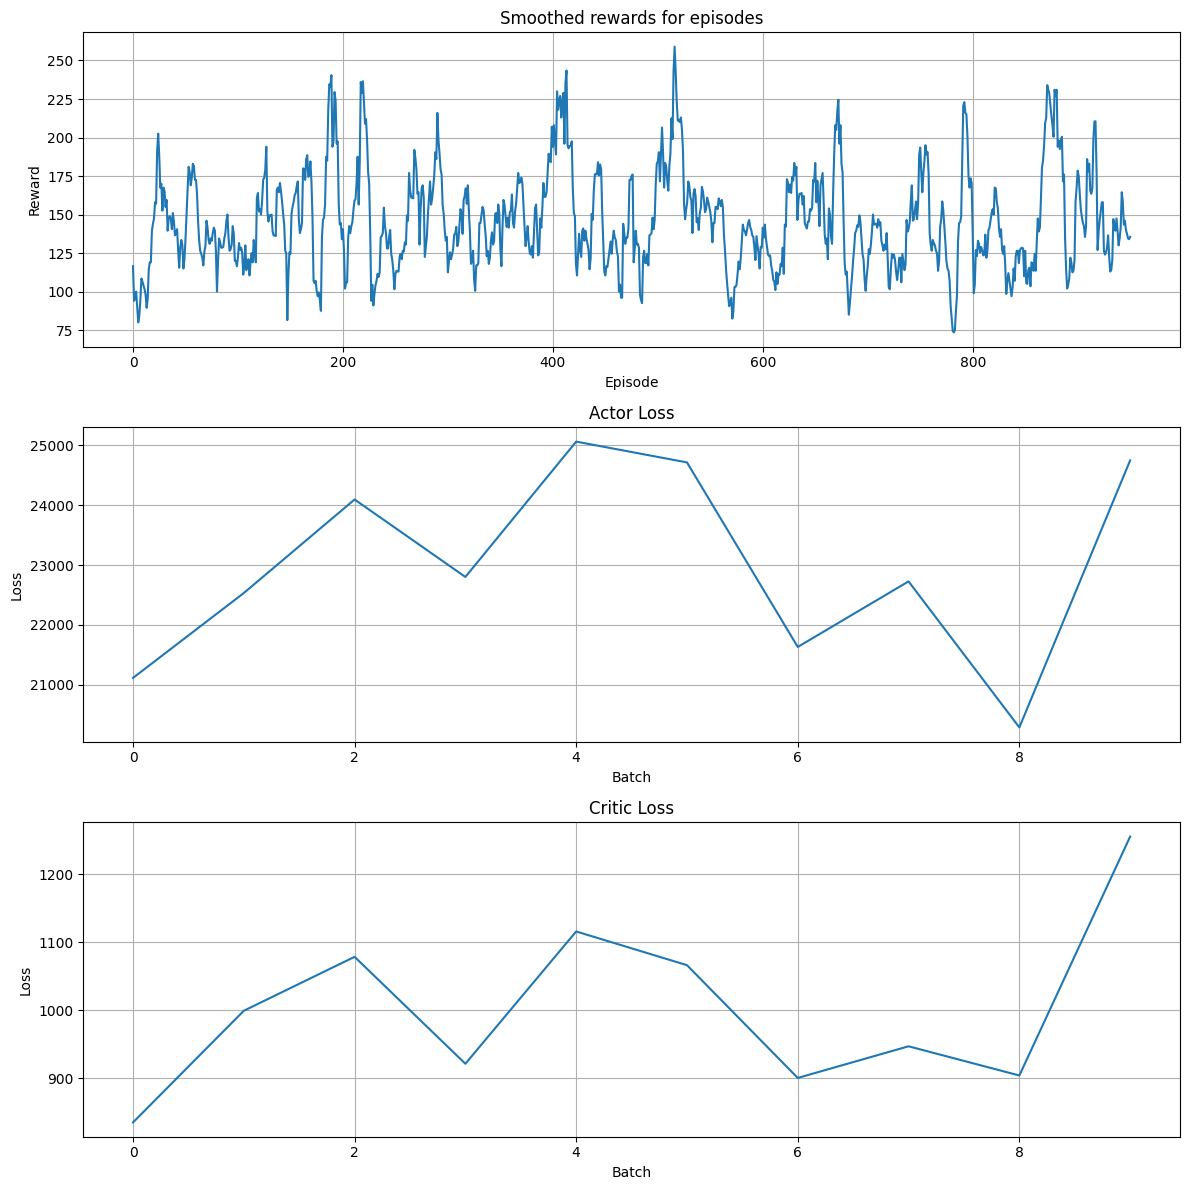

In [ ]:
agent.plot_training_results()

## Анализ результатов обучения

In [ ]:
agent.analyze_results()

Average reward: 146.02 ± 94.91
Maximum reward: 650.00
Minimum reward: 0.00
Average reward over last 100 episodes: 154.80 ± 112.32
Reward coefficient of variation: 0.6500
Convergence rate: 0.1835 rewards/interval
Computational efficiency: 0.62 episodes/second
Total training time: 1547.10 seconds


## Абляционное исследование

In [ ]:
agent.ablation_study()


Testing configuration: A2C
Average reward: 139.95

Testing configuration: A2C + V-trace
Average reward: 134.55

Testing configuration: A2C + Epsilon-greedy
Average reward: 165.00

Testing configuration: A2C + V-trace + Epsilon-greedy
Average reward: 156.35

Ablation study results:
A2C: 139.95
A2C + V-trace: 134.55
A2C + Epsilon-greedy: 165.00
A2C + V-trace + Epsilon-greedy: 156.35


## Запись видео

In [ ]:
# Для отображения видео
def show_video_mediapy(video_path):
    """Отображение видео с помощью mediapy"""
    try:
        media.show_video(media.read_video(video_path), fps=30)
    except Exception as e:
        print(f"Error displaying video with mediapy: {e}")

In [ ]:
video_path = agent.record_best_episode_video("best_episode.mp4", fps=30)
if video_path:
    show_video_mediapy(video_path)

Recording best episode video...
Best episode: #476 with reward 650.0
Video recorded: 669 frames, size 160x210
Video saved as best_episode.mp4
Reward in recorded episode: 155.0


## Заключение и рекомендации

Основные компоненты:
1. Распределенный A2C:
   - Использует несколько параллельных рабочих для сбора опыта
   - Глобальная сеть для координации обучения
   - Асинхронное обновление параметров
2. V-trace коррекция:
   - Off-policy коррекция для улучшения стабильности
   - Поддержка импортанс сэмплинга
   - Контроль дисперсии через обрезку весов
3. Исследовательские стратегии:
   - Epsilon-greedy: баланс между эксплуатацией и исследованием
   - Boltzmann: softmax-исследование с температурой
   - Стандартная: базовая стратегия на основе политики
4. Обработка Atari:
   - Предобработка кадров (градации серого, размер 84x84)
   - Стекинг 4 последовательных кадров для временной осведомленности
   - Сверточные сети для обработки изображений
Преимущества:
- Высокая стабильность обучения
- Хорошая параллелизация
- Поддержка off-policy обучения через V-trace
- Гибкие исследовательские стратегии
Недостатки:
- Требует больше вычислительных ресурсов
- Может быть менее sample-efficient по сравнению с PPO

Рекомендации:
1. Экспериментировать с различными стратегиями разведки (например, исследование на основе подсчетов);
2. Настроить количество работников на основе имеющихся вычислительных ресурсов;
3. Реализация приоритетного опыта воспроизведения для дальнейших улучшений;
4. Регулировка коэффициента обрезки V-TRACE на основе характеристик среды;
5. Добавить адаптивную настройку learning rate;
6. Попробовать другие среды Atari для сравнения производительности.